# Donation Analysis

Wellcome to this Jupyter Notebook. Below you will see code that will perform some

- Exploratory Analysis
- Data Visualisation
- Machine Learning

on some (fake) donation data. Important - as data is made up it is quite weird.

We were going to do an example of network analysis but decided against it as it uses additional tools outside of jupyter notebook.

You can run each cell by selecting it and clicking run in the toolbar above. Cells sometimes need to be run in order.

Below is a cell where the data is imported and then manipulated into a Pandas Dataframe from which we can do some analysis.

In [1]:
import pandas as pd

donor_data = pd.read_csv("donor_data.csv")

ids = []
dates = []
types = []
events = []
amounts = []
quarters = [] # new feature created for association analysis

def which_quarter(x):
    if x <= 91:
        return "first"
    elif 91 < x and x <= 182:
        return "second"
    elif 182 < x and x <= 273:
        return "third"
    else:
        return "fourth"

for key, value in donor_data.iterrows():
    donation = value[0]
    
    donor_id = donation.split("[")[0].replace(" ", "")
    date = donation.split("[")[1].split(",")[0].replace(" ", "")
    donation_type = donation.split("[")[1].split(",")[1].replace(" ", "")
    event = donation.split("[")[1].split(",")[2][1:].replace(" ", "")
    amount = donation.split("[")[1].split(",")[3][:-1].replace(" ", "")
    quarter = which_quarter(int(date))
    
    ids.append(donor_id)
    dates.append(date)
    types.append(donation_type)
    events.append(event)
    amounts.append(amount)
    quarters.append(quarter)
    
donor_data = pd.DataFrame({"id" : ids, "date" : dates, "type" : types,
                           "event" : events, "amount" : amounts,
                           "quarter" : quarters})

donor_data[["id", "date", "amount"]] = donor_data[["id", "date", "amount"]].apply(pd.to_numeric)
donor_data.set_index("id", inplace=True)

donor_data.head()
    

,date,type,event,amount,quarter
id,,,,,
58,179,Single,B10K,13,second
19,131,Repeated,N,5,second
20,165,Repeated,B10K,15,second
35,340,Single,B10K,2,fourth
37,263,Single,B10K,2,third


## Exploratory Analysis

We'll take each variable and see what we can find.

### Date
To simplify things the dates run from 1 to 365 representing the days in a normal calendar year. Let's have a look at donation frequency.

[Text(0, 0.5, 'Number of Donations'),
 Text(0.5, 0, 'Day'),
 Text(0.5, 1.0, 'Donation Frequency Histogram')]

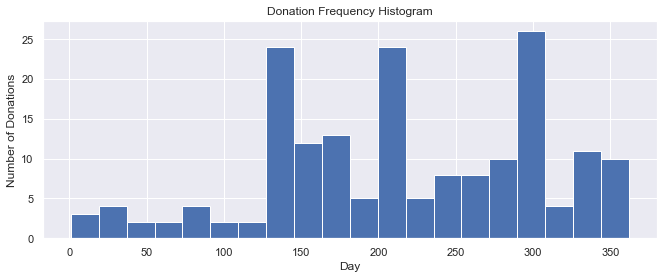

In [50]:
import seaborn as sns

# change figure size
sns.set(rc={'figure.figsize':(11, 4)})

ax = donor_data["date"].hist(bins=20)
ax.set(title = "Donation Frequency Histogram", 
       xlabel = "Day", ylabel="Number of Donations")


Things to note:

- slow start to the year
- peak number of donations around 140 days, 200 days, 300 days

Later we'll look at events to see if that can explain the patterns we see here.

Let's have a look at the donations not linked to any event (also not legacy).

[Text(0, 0.5, 'Number of Donations'),
 Text(0.5, 0, 'Day'),
 Text(0.5, 1.0, 'Donation Frequency Histogram (No Event, Legacy Removed)')]

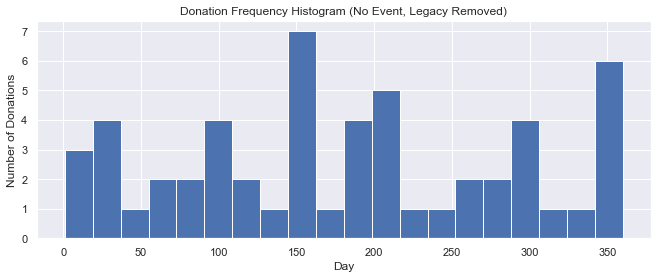

In [51]:
title = "Donation Frequency Histogram (No Event, Legacy Removed)"

ax = donor_data[(donor_data["event"] == "N") & 
                (donor_data["type"] != "Legacy")]["date"].hist(bins=20)

ax.set(title = title, xlabel = "Day", ylabel = "Number of Donations")

This is much more uniform however still peaks - suggests people may make donations due to attending events but not always specify the event when making the donation.

Lets look at the amounts data.

### Amounts

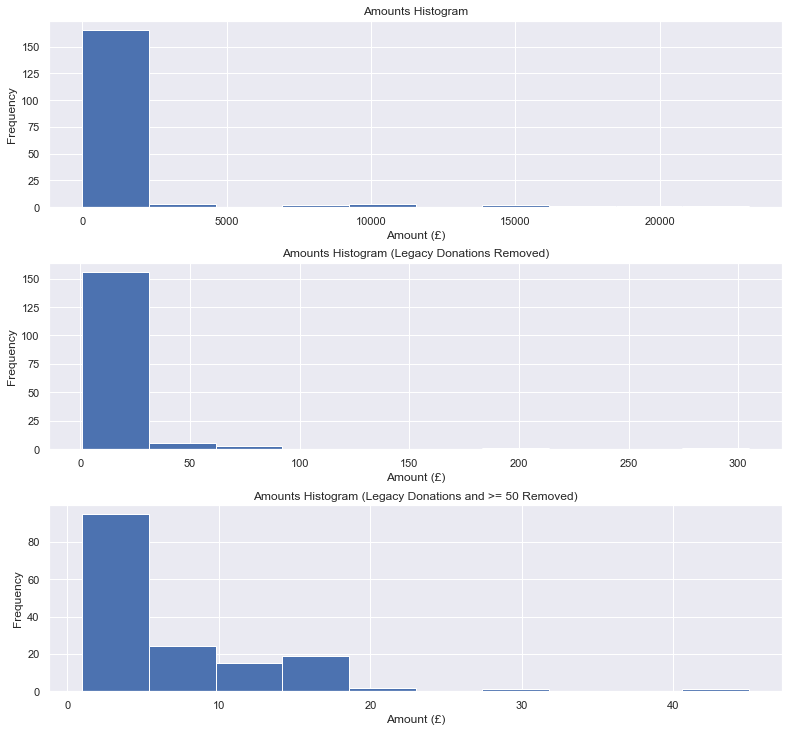

In [59]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(11, 10))

fig.tight_layout()

donor_data["amount"].hist(ax=axs[0])

donor_data[donor_data["type"] != "Legacy"]["amount"].hist(ax=axs[1])

donor_data[(donor_data["type"] != "Legacy") &
           (donor_data["amount"] < 50)]["amount"].hist(ax=axs[2])

axs[0].set(title = "Amounts Histogram", 
           xlabel = "Amount (£)", ylabel = "Frequency")
axs[1].set(title = "Amounts Histogram (Legacy Donations Removed)", 
           xlabel = "Amount (£)", ylabel = "Frequency")
axs[2].set(title = "Amounts Histogram (Legacy Donations and >= 50 Removed)", 
           xlabel = "Amount (£)", ylabel = "Frequency")

fig.subplots_adjust(hspace=0.3)

Donation amounts data can be tricky. It's massively skewed towards smaller donations. Additionally legacy donations can screw with results as they are so large. It's common to remove them when conducting further analysis as they work in very different ways to other donations.

Let's check for an exponential distribution then create sensible buckets in case its necessary for further analysis.

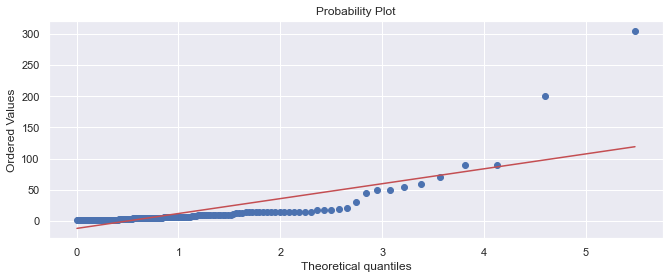

In [5]:
import scipy.stats as stats

amounts_non_legacy = donor_data[donor_data["type"] != "Legacy"]["amount"]

plot = stats.probplot(amounts_non_legacy, dist=stats.expon, plot=plt)

:( well exponential doesn't look like a good fit - you'll have to take my word that it normally is.

Anyway for the buckets lets do something like this:

0-10
10-100
100-1000
1000-

In [6]:
sizes = []

for amount in donor_data["amount"]:
    if amount < 10:
        sizes.append("small")
    elif (amount >= 10) & (amount < 100):
        sizes.append("medium")
    elif (amount >= 100) & (amount < 1000):
        sizes.append("large")
    else:
        sizes.append("huge")
        
donor_data["size"] = sizes

donor_data.head()

,date,type,event,amount,quarter,size
id,,,,,,
58,179,Single,B10K,13,second,medium
19,131,Repeated,N,5,second,small
20,165,Repeated,B10K,15,second,medium
35,340,Single,B10K,2,fourth,small
37,263,Single,B10K,2,third,small


### Events

First let's find out what events there are and when they occur.

In [7]:
donor_data["event"].unique()

array(['B10K', 'N', 'C', 'S'], dtype=object)

These correspond respectively to Bristol 10k, No event, Christmas Meal and Summer Fete

Text(0, 0.5, 'Frequency')

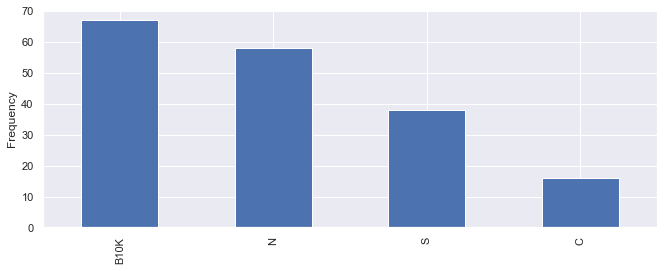

In [61]:
donor_data["event"].value_counts().plot(kind='bar').set_ylabel("Frequency")

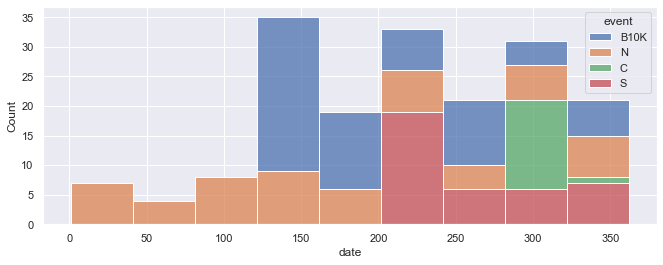

In [9]:
sns.histplot(donor_data, x="date", hue="event", multiple="stack")

From the above graphs we see B10K generates the most donations and seems to occur around day 150. We can also infer that the summer fete occurs around day 200 and the Christmas meal around day 300.

### Type

Text(0, 0.5, 'Frequency')

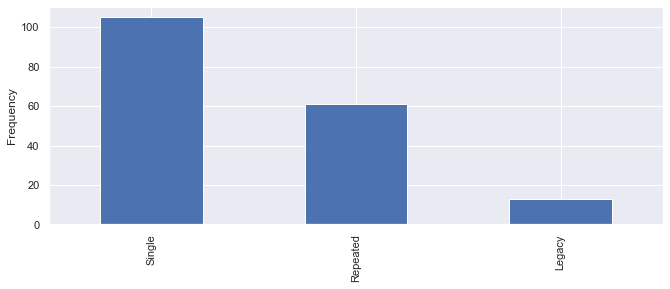

In [62]:
donor_data["type"].value_counts().plot(kind='bar').set_ylabel("Frequency")

Repeated donations are good. We want to find associations between features and repeated donations.

In [11]:
from scipy.stats import chi2_contingency

explanatory_features = ["quarter", "event", "size"]

for feature in explanatory_features:
    obs = pd.crosstab(donor_data["type"], donor_data[feature])
    chi2 = chi2_contingency(obs)
    
    print(feature + " vs type:    test-statistic = {0:.2f}".format(chi2[0]) + 
          "    p-value = {0:.2f}".format(chi2[1]))

quarter vs type:    test-statistic = 6.87    p-value = 0.33
event vs type:    test-statistic = 58.41    p-value = 0.00
size vs type:    test-statistic = 187.76    p-value = 0.00


So there isn't significant association between quarter and type but there is between event and type. Let's take a closer look at the contingency table.

In [12]:
pd.crosstab(donor_data["type"], donor_data["event"])

event,B10K,C,N,S
type,,,,
Legacy,1,6,4,2
Repeated,8,3,28,22
Single,58,7,26,14


Looking at the contingency table we see most repeated donations come from no donations and the summer fete is the best generator of repeated donations.

Let's move on to something more complicated - machine learning.

## Machine Learning (Classifcation with Logistic Regression)

We're gonna look at predicting whether a donation is repeated or not, then analyse the coefficients to see if we can discover what influences this.

Here's the process:

- Remove legacy donations
- Convert categorical explanatory variables into dummy variables
- Create response variable (1 for repeated, 0 for single)
- Split into train and test data
- Check model performance
- Analyse Coefficients



In [43]:
X = donor_data[donor_data["type"] != "Legacy"]

X = pd.get_dummies(X[['event','quarter','size']])

y = []

for i in donor_data["type"]:
    if i == "Single":
        y.append(0)
    elif i == "Repeated":
        y.append(1)

print(X.head())
print(y[0:5])

    event_B10K  event_C  event_N  event_S  quarter_first  quarter_fourth  \
id                                                                         
58           1        0        0        0              0               0   
19           0        0        1        0              0               0   
20           1        0        0        0              0               0   
35           1        0        0        0              0               1   
37           1        0        0        0              0               0   

    quarter_second  quarter_third  size_large  size_medium  size_small  
id                                                                      
58               1              0           0            1           0  
19               1              0           0            0           1  
20               1              0           0            1           0  
35               0              0           0            0           1  
37               0           

In [44]:
t_percent = 0.8
n_rows = round(len(X)*t_percent)

Xtrain = X[:n_rows]
Xtest = X[n_rows:]

ytrain = y[:n_rows]
ytest = y[n_rows:]

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)

ytest_hat = logreg.predict(Xtest)

print(classification_report(ytest, ytest_hat))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.64      0.54      0.58        13

    accuracy                           0.70        33
   macro avg       0.68      0.67      0.67        33
weighted avg       0.69      0.70      0.69        33



In [47]:
print(logreg.coef_)

[[-1.34696458  0.16351692  0.74567422  0.43784046 -0.48974739 -0.15708584
   0.39336074  0.2535395  -0.62120957  0.73102014 -0.10974356]]


Most influential in favor of repeated: 3rd variable and 10th variable
Most influential against repeated: first variable

In [49]:
X.head(0)

,event_B10K,event_C,event_N,event_S,quarter_first,quarter_fourth,quarter_second,quarter_third,size_large,size_medium,size_small
id,,,,,,,,,,,


- Bristol 10k not good at generating repeated donations.
- Most repeated donations not linked to an event.
- Most repeated donations were of a medium size.
- Quarter not particuarly impactful

## Summary

During this interactive session we

- Imported data into a pandas dataframe
- Produced histograms of donation frequency using seaborn
- Looked at the impact of legacy donations on the donation amount distribution
- Used a QQ plot to check for quality of fit of an exponential distribution
- Learnt how to bucket donation data in a sensible way
- Produced a complex chart overlaying events onto the donation frequency histogram
- Completed association analysis to try to understand what drives repeated donations
- Used machine learning (logistic regression) to further analysis this

How much better is this than Excel? :)